<a href="https://colab.research.google.com/github/danaigkritz/MLF/blob/main/meditterenea_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
################
#   Imports    #
################
!pip install keras_tuner
!pip install tensorflow
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import matplotlib.patches as mpatches
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
################
# Folder Paths #
################
test_folder = '/content/drive/MyDrive/Test'

train_labels_file = '/content/drive/MyDrive/label_train.csv'

train_folder = '/content/drive/MyDrive/Train'

In [69]:
####################################
# Fumctions for data preprocessing #
####################################

def load_test_data(folder):
    X_test = []
    filenames = []
    for file in os.listdir(folder):
        if file.endswith('.npy'):
            sample_id = int(file.replace('.npy', ''))
            sample = np.load(os.path.join(folder, file))
            X_test.append(sample)
            filenames.append(sample_id)
    X_test = np.array(X_test)
    filenames = np.array(filenames)
    return X_test, filenames

def load_train_data(df, folder):
    X = []
    y = []
    for idx, row in df.iterrows():
        sample_id = row['ID']
        label = row['target']
        sample = np.load(os.path.join(folder, f"{sample_id}.npy"))
        X.append(sample)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [70]:
####################################
# Functions for data visualization #
####################################

def count_target_values(csv_file):
    try:
        # Read the CSV file
        df = pd.read_csv(csv_file)

        # Check if 'target' column exists
        if 'target' not in df.columns:
            print("The 'target' column was not found in the file.")
            return

        # Count the occurrences of each unique value in 'target'
        value_counts = df['target'].value_counts()

        # Print the results
        print("Counts of each unique value in 'target':")
        print(value_counts)

        return value_counts.to_dict()

    except FileNotFoundError:
        print(f"File '{csv_file}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

def plot_pca_projection(X, y, class_names=None, n_components=2, figsize=(8, 6)):
    """
    Plots a PCA projection of image data.

    Parameters:
        X (numpy.ndarray): Image data of shape (n_samples, height, width, channels).
        y (numpy.ndarray): Labels of shape (n_samples,).
        class_names (dict): Optional mapping from class indices to names.
        n_components (int): Number of PCA components to project (default=2).
        figsize (tuple): Size of the plot (default=(8, 6)).
    """
    # Flatten images to 2D for PCA
    X_flat = X.reshape(X.shape[0], -1)

    # Fit PCA and transform
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_flat)

    # Plot
    plt.figure(figsize=figsize)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='Set1', s=30)
    plt.title("PCA Projection of Image Data")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)

    # Create custom legend
    if class_names is None:
        class_names = {label: f"Class {label}" for label in np.unique(y)}

    colors = [scatter.cmap(scatter.norm(i)) for i in class_names.keys()]
    patches = [mpatches.Patch(color=colors[i], label=class_names[i]) for i in class_names]

    plt.legend(handles=patches, title='Class')
    plt.show()


def plot_sample_images_per_class(X, y, samples_per_class=5, cmap='gray'):
    """
    Plots a grid of sample images for each class.

    Parameters:
    - X: array-like, shape (n_samples, height, width, channels)
         Image data.
    - y: array-like, shape (n_samples,)
         Labels corresponding to the images.
    - samples_per_class: int
         Number of images to display per class.
    - cmap: str
         Color map to use for displaying images (default: 'gray').
    """
    classes = np.unique(y)
    plt.figure(figsize=(samples_per_class * 2, len(classes) * 2))

    for idx, cls in enumerate(classes):
        idxs = np.where(y == cls)[0][:samples_per_class]
        for j, img_idx in enumerate(idxs):
            plt_idx = idx * samples_per_class + j + 1
            plt.subplot(len(classes), samples_per_class, plt_idx)
            plt.imshow(X[img_idx], cmap=cmap)
            plt.title(f"Class {cls}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

def plot_average_image_per_class(X, y, cmap='gray'):
    """
    Plots the average image for each class.

    Parameters:
    - X: array-like, shape (n_samples, height, width, channels)
         Image data.
    - y: array-like, shape (n_samples,)
         Labels corresponding to the images.
    - cmap: str
         Color map to use for displaying images (default: 'gray').
    """
    classes = np.unique(y)
    plt.figure(figsize=(len(classes) * 3, 3))

    for idx, cls in enumerate(classes):
        mean_img = X[y == cls].mean(axis=0)
        plt.subplot(1, len(classes), idx + 1)
        plt.imshow(mean_img, cmap=cmap)
        plt.title(f"Avg. Class {cls}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [71]:
############################
# Function model training  #
############################

def train_model_with_early_stopping(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=5, class_weights={0: 1.0,1: 1.0,2: 1.0}, patience=20, min_delta=1e-7, reduce_lr_callback=None):
    """
    Trains the model with early stopping and optional learning rate reduction.

    Parameters:
    - model (tensorflow.keras.Model): The compiled model to be trained.
    - X_train (np.ndarray): Training input data.
    - y_train (np.ndarray): Training labels.
    - X_val (np.ndarray): Validation input data.
    - y_val (np.ndarray): Validation labels.
    - epochs (int): Number of epochs to train the model.
    - batch_size (int): Batch size for training.
    - class_weights (dict): Class weights for balancing classes.
    - patience (int): Number of epochs with no improvement after which to stop.
    - min_delta (float): Minimum change to qualify as an improvement for early stopping.
    - reduce_lr_callback (callback, optional): A callback to reduce learning rate if necessary (e.g., ReduceLROnPlateau).

    Returns:
    - history: Training history object containing the loss and accuracy values for each epoch.
    """

    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',        # Monitor validation loss
        patience=patience,         # Number of epochs with no improvement after which to stop
        min_delta=min_delta,       # Minimum change to qualify as improvement
        restore_best_weights=True  # Restore model weights from the epoch with the best value of monitored metric
    )

    # Train the model with early stopping
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr_callback] if reduce_lr_callback else [early_stopping],
        class_weight=class_weights
    )

    plot_training(history)

    # Print information about early stopping
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch + 1}")
        print(f"Best epoch was {early_stopping.stopped_epoch + 1 - early_stopping.patience}")
    else:
        print("Early stopping did not occur. All epochs were trained.")

    return model


In [72]:
####################################
# Functions for data augmentation  #
####################################

def prepare_data(X_train_original, y_train_original):
    """
    Prepares the data by splitting into train, validation, and test sets, balancing the classes in the training set,
    and applying augmentation for minority classes.

    Parameters:
    - X_train_original: The features of the training dataset.
    - y_train_original: The labels of the training dataset.
    - samples_per_class: The number of samples per class for validation and test sets.
    - target_class_size: The number of samples per class in the training set after augmentation.

    Returns:
    - X_train, y_train, X_val, y_val, X_test_train, y_test_train: Prepared datasets.
    """

    # Normalize (Preprocessing)
    X = X_train_original / 255.0
    y = y_train_original

    y = np.array(y)
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]
    idx_2 = np.where(y == 2)[0]

    X_0, y_0 = X[idx_0], y[idx_0]
    X_1, y_1 = X[idx_1], y[idx_1]
    X_2, y_2 = X[idx_2], y[idx_2]

    # First split: train val(e.g. 80% train, 20% val)
    X_train_0, X_val_0, y_train_0, y_val_0  = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
    X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)
    X_train_2, X_val_2, y_train_2, y_val_2= train_test_split(X_2, y_2, test_size=0.2, random_state=42)

    # Define augmentation function
    def generate_augmented_data(datagen, X, y, num_augmented):
        augmented_X, augmented_y = [], []
        gen = datagen.flow(X, y, batch_size=1)
        for _ in range(num_augmented):
            x_aug, y_aug = next(gen)
            augmented_X.append(x_aug[0])
            augmented_y.append(y_aug[0])
        return np.array(augmented_X), np.array(augmented_y)

    # Augmentation parameters
    datagen = ImageDataGenerator(
        width_shift_range=0.1,
        height_shift_range=0.05,
        zoom_range=0.1,
        fill_mode='nearest',
        horizontal_flip=False,
        vertical_flip=False
    )


    # Augment if necessary to match the target class size
    target_class_size = len(X_train_0)
    n_aug_1 = max(0, target_class_size - len(X_train_1))
    n_aug_2 = max(0, target_class_size - len(X_train_2))

    X_aug_1, y_aug_1 = generate_augmented_data(datagen, X_train_1, y_train_1, n_aug_1)
    X_aug_2, y_aug_2 = generate_augmented_data(datagen, X_train_2, y_train_2, n_aug_2)

    # Combine the augmented data with the training data
    X_train = np.concatenate([X_train_0,X_train_1,X_train_2, X_aug_1, X_aug_2])
    y_train = np.concatenate([y_train_0,y_train_1, y_train_2, y_aug_1, y_aug_2])

    X_val = np.concatenate([X_val_0,X_val_1, X_val_2])
    y_val = np.concatenate([y_val_0,y_val_1,y_val_2])

    # Final checks
    print("Train:", X_train.shape, y_train.shape)
    print("Val:", X_val.shape, y_val.shape)

    return X_train, y_train, X_val, y_val




def print_class_distribution(*datasets, dataset_names=None):
    """
    Prints the class distribution for each given label dataset.

    Parameters:
    - *datasets: list of np.ndarray
        One or more label arrays (e.g. y_train, y_val, y_test)
    - dataset_names: list of str (optional)
        Names corresponding to each dataset for labeling output
    """
    if dataset_names is None:
        dataset_names = [f"Dataset {i+1}" for i in range(len(datasets))]

    for y, name in zip(datasets, dataset_names):
        unique, counts = np.unique(y, return_counts=True)
        class_distribution = dict(zip(unique, counts))
        print(f"\nFinal class distribution in {name}:")
        for cls, count in class_distribution.items():
            print(f"Class {cls}: {count} samples")


In [73]:
###########################################
# Function for plotting training history  #
###########################################

def plot_training(history):
    # Plot Loss
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

In [74]:
###########################################
#   Function for analizing the results   #
###########################################

def find_most_confused_pair(predictions, threshold=0.99):
    """
    Identifies the most common top-2 class pair among low-confidence predictions.

    Parameters:
    - predictions (np.ndarray): Array of predicted class probabilities (e.g., output from model.predict).
    - threshold (float): Confidence threshold below which a prediction is considered "not confident".

    Returns:
    - most_common_pair (tuple): The most confused pair of classes.
    - count (int): Number of times this pair occurred.
    """
    not_confident_pairs = []

    for pred in predictions:
        if np.max(pred) < threshold:
            top2 = tuple(sorted(np.argsort(pred)[-2:]))
            not_confident_pairs.append(top2)

    if not not_confident_pairs:
        print("No low-confidence predictions found.")
        return None, 0

    pair_counts = Counter(not_confident_pairs)
    most_common_pair, count = pair_counts.most_common(1)[0]

    print(f"The two classes the model is most often confused between are: {most_common_pair} "
          f"with {count} occurrences among low-confidence predictions.")

    return most_common_pair, count

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    Plots a confusion matrix using true and predicted labels.

    Parameters:
    - y_true (array-like): True class labels.
    - y_pred (array-like): Predicted class labels.
    - labels (list of str, optional): Display labels for each class.
    - title (str): Title for the plot.
    - cmap (Colormap): Color map for the plot.
    """
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=cmap)
    plt.title(title)
    plt.show()


def evaluate_model(model, X_test, y_test, return_predictions=False):
    """
    Evaluates a trained model on test data and prints accuracy, loss, and a classification report.

    Parameters:
    - model: Trained Keras model.
    - X_test (np.ndarray): Test input data.
    - y_test (np.ndarray): True labels for the test data.
    - return_predictions (bool): If True, returns y_pred and y_pred_probs.

    Returns:
    - Optionally returns y_pred, y_pred_probs if return_predictions=True.
    """
    val_loss, val_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    if return_predictions:
        return y_pred, y_pred_probs

import numpy as np

def find_not_confident_predictions(predictions, confidence_threshold=0.99):
    """
    Finds samples where the highest predicted probability is below the given threshold,
    and prints out the top 2 predicted classes and their probabilities.

    Parameters:
    - predictions (np.ndarray): Model's predicted probabilities for each sample.
    - confidence_threshold (float): The probability threshold below which a prediction is considered low-confidence.

    Returns:
    - not_confident (list): List of dictionaries containing indices, top predicted classes, and probabilities.
    """
    not_confident = []

    for i, pred in enumerate(predictions):
        max_prob = np.max(pred)
        if max_prob < confidence_threshold:
            top2_indices = np.argsort(pred)[-2:][::-1]
            top2_probs = pred[top2_indices]
            not_confident.append({
                'sample_index': i,
                'top_classes': top2_indices.tolist(),
                'top_probs': top2_probs.tolist()
            })

    print(f"Number of samples where the model was NOT {confidence_threshold*100}% confident: {len(not_confident)}\n")

    # for case in not_confident:
    #     print(f"Sample {case['sample_index']} - Top classes: {case['top_classes']}, "
    #           f"Probs: {case['top_probs']}")

    return not_confident


In [75]:
###########################################
# Function for generating the submission  #
###########################################

def generate_submission(best_model, X_test, test_ids, output_file='tuner.csv'):
    """
    Generate predictions for the test set and create a CSV submission file.

    Parameters:
    - best_model (tensorflow.keras.Model): The trained model to make predictions.
    - X_test (np.ndarray): Test input data.
    - test_ids (np.ndarray or list): IDs corresponding to the test samples.
    - output_file (str): The filename where the submission CSV will be saved.

    Returns:
    - None: Saves the prediction results to a CSV file.
    """

    # Predict the probabilities for the test set
    test_predictions = best_model.predict(X_test)

    # Get the index of the highest probability class for each sample
    test_predicted_labels = np.argmax(test_predictions, axis=1)

    # Create a DataFrame to save
    submission = pd.DataFrame({
        'ID': test_ids,
        'target': test_predicted_labels
    })

    # Save submission CSV
    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")


In [76]:
########################################
# Functions for Hyperparameter Tunning #
########################################

class StopAtAccuracy(Callback):
    def __init__(self, target=1.0):
        super().__init__()
        self.target = target

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None and val_acc >= self.target:
            print(f"\nReached {self.target*100:.2f}% validation accuracy. Stopping training.")
            self.model.stop_training = True


def build_model_2(hp):
    model = models.Sequential()

    model.add(layers.Conv2D(
        filters=hp.Int("conv1_filters", 32, 64, step=8),
        kernel_size=hp.Choice("kernel_size1", [3, 5]),
        activation="relu",
        padding="same",
         input_shape=(72, 48, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Int("conv2_filters", 32, 128, step=8),
        kernel_size=hp.Choice("kernel_size2", [3, 5]),
        activation="relu",
        padding="same"
    ))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(
        filters=hp.Int("conv3_filters", 32, 128, step=8),
        kernel_size=hp.Choice("kernel_size3", [3, 5]),
        activation="relu",
        padding="same"
    ))

    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(layers.Dropout(
        rate=hp.Float("dropout", 0.0, 0.25, step=0.1)
    ))

    model.add(layers.Dense(3, activation='softmax'))


    model.compile(optimizer=Adam(hp.Choice("learning_rate", [1e-3,3e-4,1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



In [77]:
# Loading the data

X_test, y_test = load_test_data(test_folder)

train_labels = pd.read_csv(train_labels_file)

X_train_original, y_train_original= load_train_data(train_labels, train_folder)

# Normalization of test data
X_test = X_test / 255.0


# Adding the channel dimenssion
X_test = np.expand_dims(X_test, axis=-1)


print(X_test.shape, y_test.shape)
print(X_train_original.shape, y_train_original.shape)


(120, 72, 48, 1) (120,)
(1491, 72, 48) (1491,)


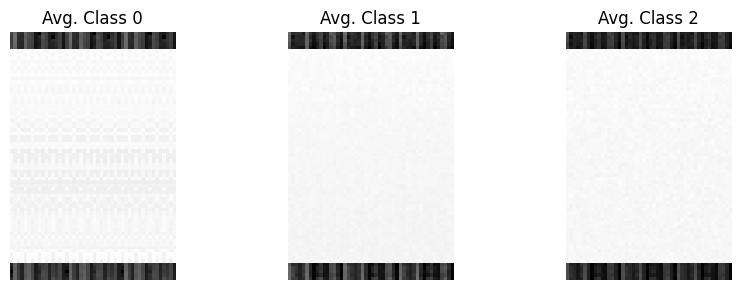

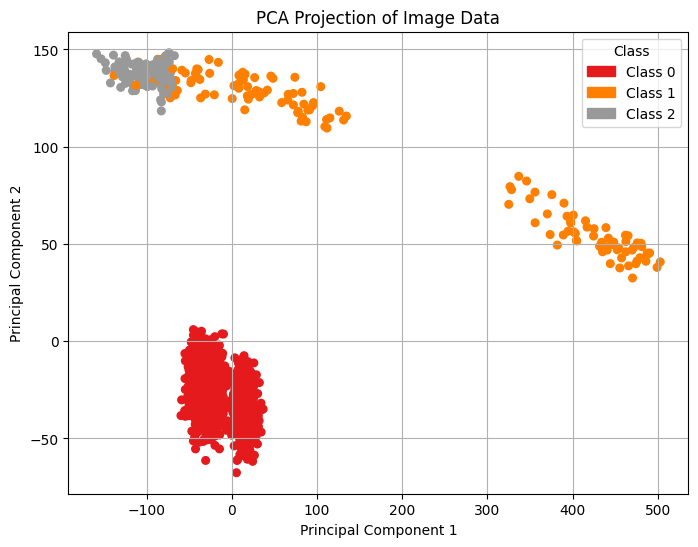

In [78]:
# Visualization of data

plot_average_image_per_class(X_train_original, y_train_original)

class_names = {0: 'Class 0', 1: 'Class 1', 2: 'Class 2'}
plot_pca_projection(X_train_original, y_train_original, class_names=class_names)


In [79]:
# Examination
# Check the amount of samples per class (balanced ?)
count_target_values(train_labels_file)

Counts of each unique value in 'target':
target
0    1209
2     141
1     141
Name: count, dtype: int64


{0: 1209, 2: 141, 1: 141}

In [80]:
# Augment data
X_train = np.expand_dims(X_train_original, axis=-1)

X_train, y_train, X_val, y_val= prepare_data(X_train, y_train_original)



print_class_distribution(y_train, y_val,
                         dataset_names=["training set", "validation set"])


Train: (2901, 72, 48, 1) (2901,)
Val: (300, 72, 48, 1) (300,)

Final class distribution in training set:
Class 0: 967 samples
Class 1: 967 samples
Class 2: 967 samples

Final class distribution in validation set:
Class 0: 242 samples
Class 1: 29 samples
Class 2: 29 samples


In [81]:
tuner2 = kt.RandomSearch(
    build_model_2,
    objective='val_accuracy',
    max_trials=100,
    executions_per_trial=1,
    directory='my_tuner_dir',
    project_name='cnn3_tuning'
)

Reloading Tuner from my_tuner_dir/cnn3_tuning/tuner0.json


In [82]:
print(X_train.shape)

(2901, 72, 48, 1)


In [ ]:
stop_at_accuracy = StopAtAccuracy(target=1.0)

class_weight= {0: 1.0, 1: 2.0, 2: 3.0}

tuner2.search(X_train, y_train,
             epochs=20,
             validation_data=(X_val, y_val),
             class_weight=class_weight,
             callbacks=[ stop_at_accuracy])

In [84]:
best_model = tuner2.get_best_models(num_models=1)[0]
best_hp = tuner2.get_best_hyperparameters(1)[0]
model=best_model
print("Best hyperparameters:")
print(f"conv1_filters: {best_hp.get('conv1_filters')}")
print(f"kernel_size1: {best_hp.get('kernel_size1')}")
print(f"conv2_filters: {best_hp.get('conv2_filters')}")
print(f"kernel_size2: {best_hp.get('kernel_size2')}")
print(f"conv3_filters: {best_hp.get('conv3_filters')}")
print(f"kernel_size3: {best_hp.get('kernel_size3')}")
print(f"dense_units: {best_hp.get('dense_units')}")
print(f"dropout: {best_hp.get('dropout')}")
print(f"learning_rate: {best_hp.get('learning_rate')}")

Best hyperparameters:
conv1_filters: 48
kernel_size1: 3
conv2_filters: 128
kernel_size2: 5
conv3_filters: 128
kernel_size3: 5
dense_units: 128
dropout: 0.0
learning_rate: 0.0003


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7867 - loss: 1.5400 - val_accuracy: 0.0967 - val_loss: 13.5327
Epoch 2/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9588 - loss: 0.2989 - val_accuracy: 0.9333 - val_loss: 0.1270
Epoch 3/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9673 - loss: 0.2388 - val_accuracy: 0.9767 - val_loss: 0.0442
Epoch 4/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9809 - loss: 0.1395 - val_accuracy: 0.9933 - val_loss: 0.0269
Epoch 5/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9718 - loss: 0.2267 - val_accuracy: 0.9833 - val_loss: 0.0991
Epoch 6/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9863 - loss: 0.0669 - val_accuracy: 0.9967 - val_loss: 0.0215
Epoch 7/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9995 - loss: 0.0088 - val_accuracy: 0.9933 - val_loss: 0.0229
Epoch 8/100
581/581 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9942 - loss: 0.0344 - val_a

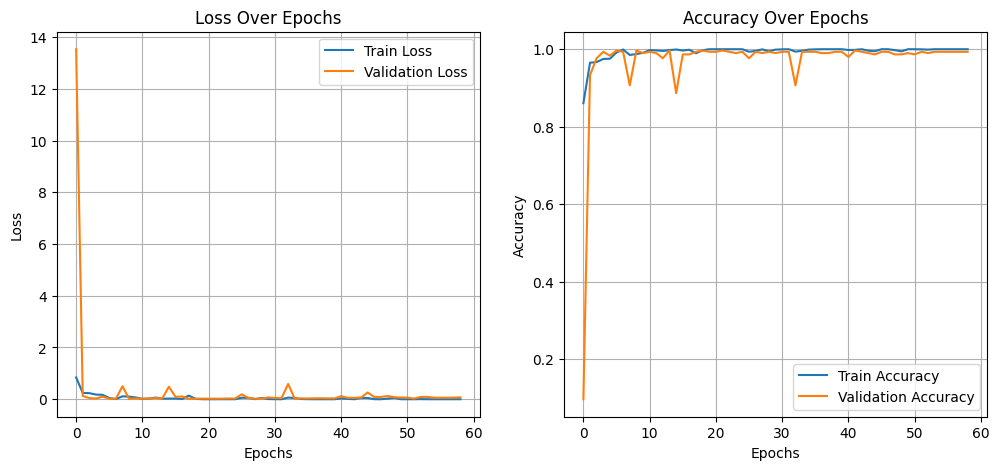

Early stopping occurred at epoch 59
Best epoch was 9


In [85]:
# Train model
model= build_model_2(best_hp)
class_weight = {0:1.0, 1:2.0, 2:3.0}
# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=50,         # Number of epochs with no improvement after which to stop
    min_delta=1e-8,       # Minimum change to qualify as improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of monitored metric
)

# Train the model with early stopping
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=5,
    callbacks=[early_stopping],
    class_weight=class_weight
)

plot_training(history)

# Print information about early stopping
if early_stopping.stopped_epoch > 0:
    print(f"Early stopping occurred at epoch {early_stopping.stopped_epoch + 1}")
    print(f"Best epoch was {early_stopping.stopped_epoch + 1 - early_stopping.patience}")
else:
    print("Early stopping did not occur. All epochs were trained.")



91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9960 - loss: 0.0090
Validation Accuracy: 0.9941
Validation Loss: 0.0156
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       967
           1       1.00      0.99      0.99       967
           2       0.98      1.00      0.99       967

    accuracy                           0.99      2901
   macro avg       0.99      0.99      0.99      2901
weighted avg       0.99      0.99      0.99      2901



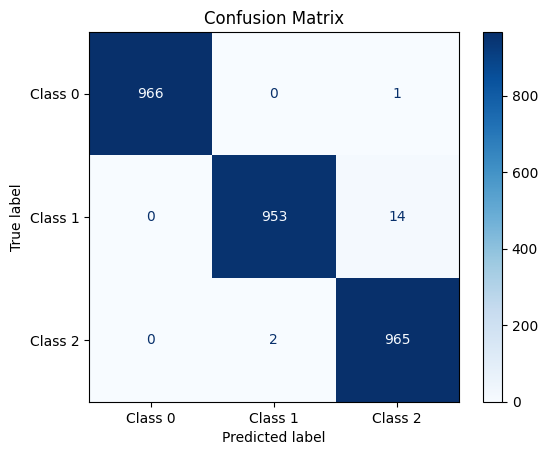

The two classes the model is most often confused between are: (np.int64(1), np.int64(2)) with 210 occurrences among low-confidence predictions.
Number of samples where the model was NOT 99.0% confident: 220



In [86]:
# Results analysis

val_loss, val_acc = model.evaluate(X_train, y_train)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

y_pred_probs = model.predict(X_train)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1', 'Class 2'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

most_confused, freq = find_most_confused_pair(y_pred_probs, threshold=0.99)

not_confident_samples = find_not_confident_predictions(y_pred_probs, confidence_threshold=0.99)


In [87]:
# Generate submission
generate_submission(best_model, X_test, y_test, output_file='tuner.csv')

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
Submission saved to tuner.csv
